In [1]:
#  DO NOT RUN (created for some specialty charts... use univstress modules only!! Truncates data at Dec-2015!)
# chap03: special charts: 3v vs 4v vs 4v_norate (grpTotUS)
# NOTE: relies on grpTotUSx00 from br003ma_stress_grpTotUS (used in chap04) (this is illogical... )
#     the difference between grpTotUS vs grpTotUSx00 is that latter includes CE variable, former does not.
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [28]:
## Note:  Need to run both versions of test variable:
#test = '_intrates'  # either '_intrates' or '_norates'
test = '_norates'

cbo = ['Lags','Lags_sUE2','Lags_sUE23'] # combo tags (for use in charts)
xvr = [['UE2','sUE2','sUE3'],['UE2','sUE3'],['UE2']]
frsq = [0,0,0] # set up list of full model adj r-sq values

In [29]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables
df = pd.read_csv("df2_3z_grpTotUSx00.csv", index_col=0)
df.rename(columns = {'AsOf' : 'Date'}, inplace= True)
adj = pd.read_csv("UE_adj.csv",index_col=0)

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])
df['Date'] = pd.to_datetime(df['Date'])
adj['Date'] = pd.to_datetime(adj['Date'])

df = df[df["Date"]<="2015-12-31"]  # truncate data extracts at 12/31/2015

## adjust DJ so coeffs are similar scale:
hs['DJ'] = hs['DJ'] / 1000
cc['DJ'] = cc['DJ'] / 1000

## history vars: lag (4q) vars for UE, HPI, CRE:
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE:
hs['UE2'] = hs['UE'] * hs['UE']

df.tail(2)

Date        Grp  IDRSSD  nbr       Cert       eTotAst        eTotLn  \
338 2015-09-30  grpC31x00       0   63  1270053.0  1.098663e+10  5.516840e+09   
339 2015-12-31  grpC31x00       0   56  1142990.0  1.102828e+10  5.625973e+09   

          eALLL      eOREO          eGW    ...         eTotrb  eALLL_Ln  \
338  78035635.0  4948766.0  229695672.0    ...      14.110077  1.414499   
339  77435954.0  4494463.0  231090104.0    ...      14.103629  1.376401   

         mxCx    mxSfFst     mxCRE       mxCI     mxCard      mxDDA  \
338  1.886896  20.118700  7.836288  23.469317  10.722295  31.985122   
339  1.858414  19.886198  7.920475  23.522074  11.031083  31.440765   

       eRWA_TA   lnTotAst  
338  73.418518  23.119945  
339  73.391569  23.123729  

[2 rows x 322 columns]

In [30]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

rclst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
qclst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']

irlst = ['T3m','T5y','T10y','BBB','Mort','Prime']  # interest rate variables to remove if 'norates'
#cccol = [x for x in cccol if x not in irlst]  ## removes interest rate vars from cccol (ccar var columns)

qtyp = 4  # rc prods

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

In [31]:
grp = 'grpTotUS'  ## use grpTotUS when don't want CE variable, use grpTotUSx00 if want CE variable
grporig = grp
grp

'grpTotUS'

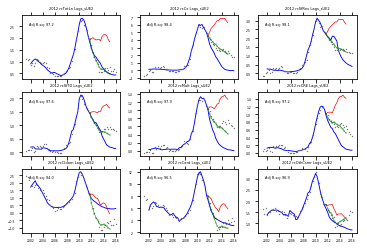

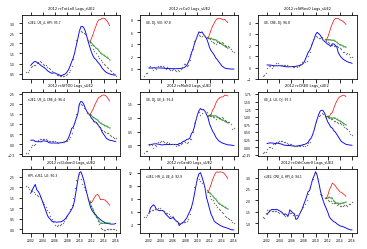

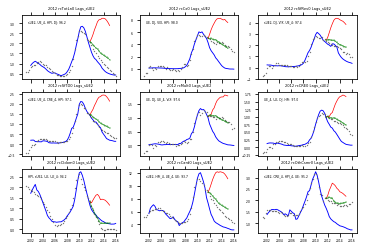

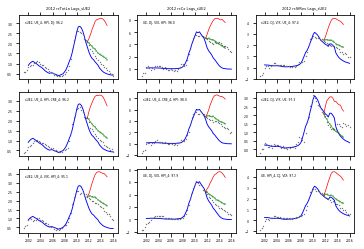

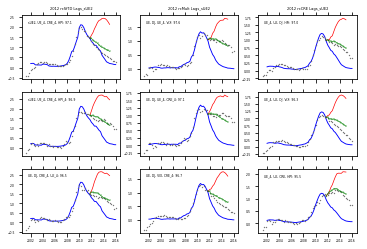

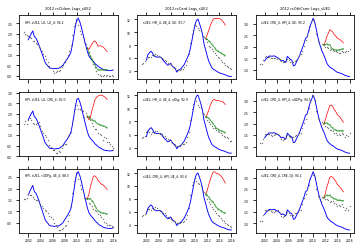

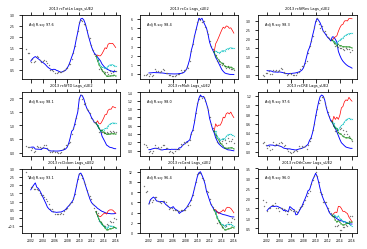

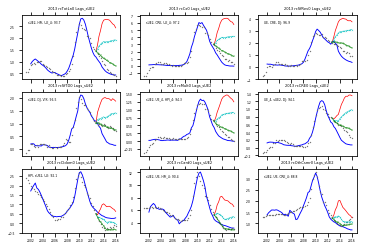

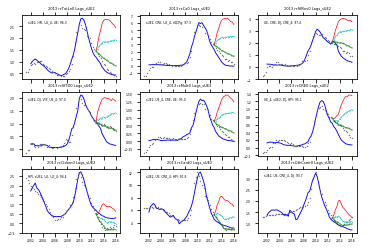

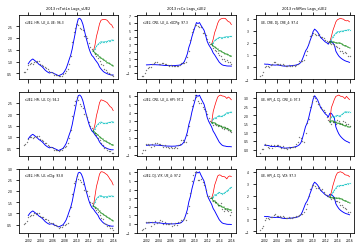

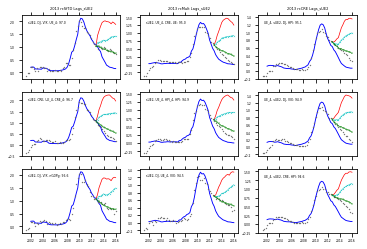

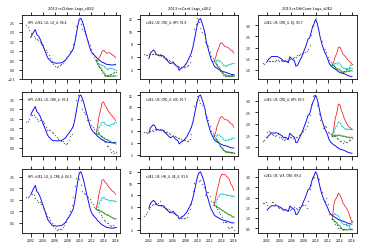

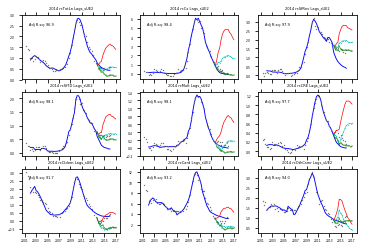

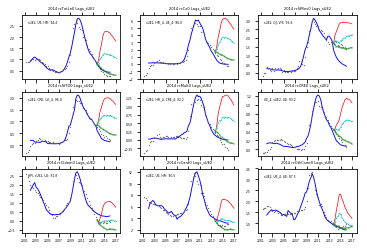

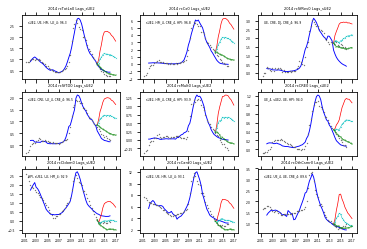

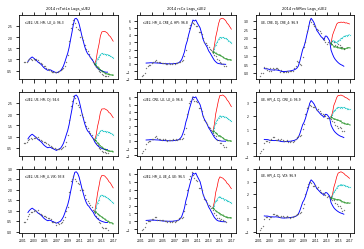

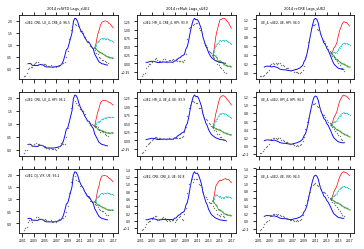

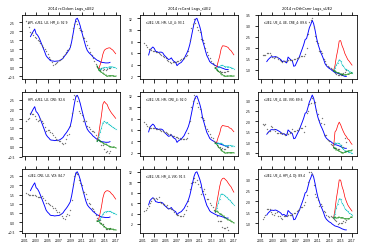

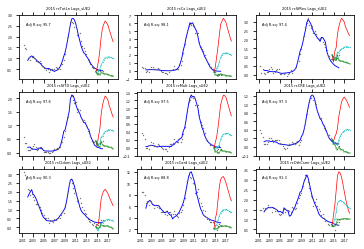

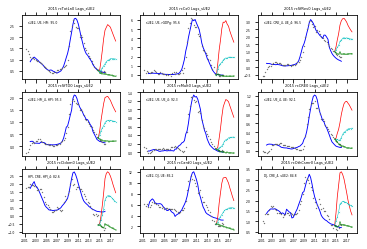

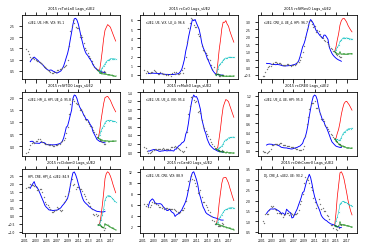

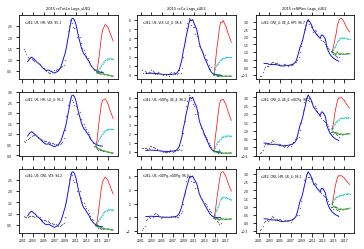

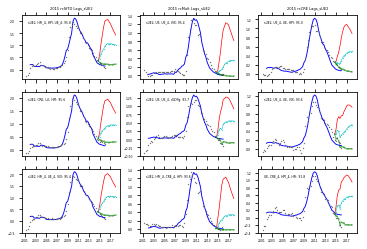

In [32]:
dfc = df[df['Grp']==grp+'x00']  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='all', inplace=True)

## begin cbo loops here:
## combo number:
#cbon = 0 # Lags
cbon = 1  # Lags_sUE2
#cbon = 2 # Lags_sUE23

#####################################################################################################
## yr loops begin here:
for ccar in [2012,2013,2014,2015]:
    
  dtst = pd.to_datetime('2001-03-31')  # data start date for all CCAR years
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
  
  uvr = "adj" + str(ccar-2000)  ## colname for UE adj factors
  
  ## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
  ccx = cc[(cc['CCAR'] == ccar)]  # ccx contains forecast periods
  ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)
  
  ## CCAR vars: create lag (4q) terms for UE, HPI, CRE:
  ccx[['UE_4','HPI_4','CRE_4']] = ccx[['UE','HPI','CRE']].shift(4)
  ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-2)+'-09-30',\
                                                                          ['UE','HPI','CRE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-2)+'-12-31',\
                                                                          ['UE','HPI','CRE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-1)+'-03-31',\
                                                                        ['UE','HPI','CRE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4']] = hs.ix[hs.Date==str(ccar-1)+'-06-30',\
                                                                        ['UE','HPI','CRE']].values
  
  ## CCAR vars: squared terms for UE and UE_4:
  ccx['UE2'] = ccx['UE'] * ccx['UE']
  
  ccx.sort_index(by=['Scen','Date'], inplace=True)
  ccx = ccx.merge(adj[['Date',uvr]],how='left',on='Date')
  ccx[uvr].fillna(1, inplace=True)
  ccx.sort_index(by=['Scen','Date'], inplace=True)
  ccx['sUE2'] = ccx['UE2'] * ccx[uvr] * ccx[uvr]
  ccx['sUE3'] = ccx['sUE2'] * ccx['UE'] * ccx[uvr]
  ccx.drop(uvr, axis=1, inplace=True)
  ccx.sort_index(by=['Scen','Date'], inplace=True)
  
  cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
  
  suff = cbo[cbon]
  cccol = [k for k in cccol if k not in xvr[cbon]]   ## removes vars listed in xvr list
  if 'norat' in test: cccol = [k for k in cccol if k not in irlst]   ## removes vars listed in xvr list
  
  Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables
  
  hsf = hs.copy()
  
  ## sUE2 variable = UE2*adj*adj:
  hsf = hsf.merge(adj[['Date',uvr]],how='left',on='Date')
  hsf[uvr].fillna(1, inplace=True)
  hsf['sUE2'] = hsf['UE2'] * hsf[uvr] * hsf[uvr]
  hsf['sUE3'] = hsf['sUE2'] * hsf['UE'] * hsf[uvr]
  hsf.drop(uvr, axis=1, inplace=True)
  hsf = hsf.merge(dfc,how='inner',left_on='Date',right_on='Date') # merge fail rates into history file (hs)
  hsx = hsf[(hsf['Date'] >= dtst) & (hsf['Date'] <= dtend)] # historic periods
  
  ccs = ccx.copy()  # CCAR scenarios for selected year
  ccs['Intercept'] = 1  # to set up fitting model
  
  hsf['Intercept'] = 1   # to set up fitting for all available history
  hsz = hsf[(hsf['Date'] >= dtst)] # historic periods until current date
  
  # start full model loop here:
  for rc in curlst:
    eqn = rc + " ~ " + " + ".join(cccol)
    yt, Xt = dmatrices(eqn , data=hsx, return_type='dataframe')
    mod = sm.OLS(yt, Xt)
    res_tot = mod.fit()
    pred_tot = res_tot.predict(Xt)
    p_tot = res_tot.predict(ccs[Xcol])  # forecasts
    ccs['pred'] = p_tot
    ## create table holding actual, fitted, and forecasted fail rates
    frt = hsz[['Date', rc]]
    frt['Fit'] = res_tot.predict(hsz[Xcol])
    frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base']
    frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base','Adverse']
    frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
    frt.set_index('Date', drop=True, inplace=True)
  
    frt2 = frt.copy()
    frt2.columns = [[rc]*len(frt.columns),frt.columns]
  
    prm = res_tot.params
    prm['rsq'] = res_tot.rsquared
    prm['rsq_adj'] = res_tot.rsquared_adj
    prm2 = pd.DataFrame(prm)
    prm2.columns = [rc]
  
    if rc == curlst[0]:
      frt3 = frt2.copy()
      prm3 = prm2.copy()
    else:
      frt3 = frt3.merge(frt2, how='outer', left_index=True, right_index=True)
      prm3 = prm3.merge(prm2, how='outer', left_index=True, right_index=True)
  
  frt3.to_csv(grp + "_" + str(ccar) + "_full_9fcst_" + str(qtyp) + "q_" + suff + test + ".csv")
  prm3.to_csv(grp + "_" + str(ccar) + "_full_9param_" + str(qtyp) + "q_" + suff + test + ".csv")
  
  if cbon == 0:
    frt3v0 = frt3.copy()  
  elif cbon == 1:
    frt3v1 = frt3.copy()  
  elif cbon == 2:
    frt3v2 = frt3.copy()  
  
  rlst = prm3.ix['rsq_adj'].values
  xax = list(frt3.index)
  plt.rcParams.update({'font.size': 3})
  
  styp = suff
  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.title(str(ccar)+" "+curlst[i]+" "+styp)
    plt.annotate("Adj R-sq: "+str(round(rlst[i]*100,1)), xy=(0.07, 0.85),\
                 xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    if i < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full9_'+styp+test+'.png', dpi=400, bbox_inches='tight')
  plt.show()
  
  ### build 3-var models:
  def df1_topx(group):
    return group.sort_index(by='r1', ascending=False)[:topx]
  
  df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
  for rc in curlst:
    for v in cccol:
      y, X = dmatrices( rc + ' ~ ' + v , data=hsx, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)
  
  df1g = df1.groupby(['rc'])
  df1t = df1g.apply(df1_topx)
  df1t.index = np.arange(len(df1t))
  
  # stores r-sq values for all 2-var combos:
  df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
  st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs
  
  for idx, row in df1t.iterrows():
    for v in cccol:
      if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
        pass
      else:
        y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsx, return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj},\
                         ignore_index=True)
        st2.add(frozenset({row['rc'], v, row['v1']}))
  
  # function to select topx for each lead variable:
  def get_topx_2var(group):
    return group.sort_index(by=['r2','r1'], ascending=False)[:topx]
  
  grouped = df2.groupby(['rc','v1'])
  df2a = grouped.apply(get_topx_2var)
  df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
  df2a.index = np.arange(len(df2a))
  
  # prep for 3-var combos:
  # stores r-sq values for all 3-var combos:
  df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
  cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
  st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples
  
  for idx, row in df2a.iterrows():
    for v in cccol:
      if (row['v1'] == v) | (row['v2'] == v) :
        pass
      elif {row['rc'], v , row['v1'], row['v2']} in st3:
        pass
      else:
        y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsx,\
                         return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                          'r3': res.rsquared_adj},ignore_index=True)
        st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3']
        cf3 = cf3.append(cm.ix[0])
  
  cf3 = cf3.reset_index(drop=True)
  df3 = df3.reset_index(drop=True)
  df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)
  
  # function to select top 3 for each lead variable:
  def get_topx_3var(group):
    return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]
  
  def get_topn_rc(group):
    return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]
  
  df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
  df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
  df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
  df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
  df3b.index = np.arange(len(df3b))

  ### sections to generate forecasts for all 3-var models:

  for idx, row in df3b.iterrows():
    rc = row['rc']
    x = idx
    mdx = idx % topn
    eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
    pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
    yc, Xc = dmatrices(eqnc , data=hsx, return_type='dataframe')
    modc = sm.OLS(yc, Xc)
    res_c = modc.fit()
    pred_tot = res_c.predict(hsz[pvar])
    p_tot = res_c.predict(ccs[pvar])  # forecasts
    ccs['pred'] = p_tot
    ## create table holding actual, fitted, and forecasted fail rates
    frt = hsz[['Date', rc]]
    frt['Fit'] = res_c.predict(hsz[pvar])
    frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base']
    frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base','Adverse']
    frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
    frt.set_index('Date', drop=True, inplace=True)

    frt2 = frt.copy()

    frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

    if x == 0:
      frt3b = frt2.copy()
    else:
      frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)

  frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
  frt3s.reset_index(drop=False, inplace=True)
  frt3s.columns = ['rc','scen','amt']
  frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
  frpv.reset_index(drop=False, inplace=True)
  frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
  dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
  frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
  ####################################################################
  #   NOTE:  this section will determine ordering of models in charts:
  #          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
  #frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
  #frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
  frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
  ####################################################################
  #frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
  frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
  ####################################################################
  frpv.reset_index(drop=True, inplace=True)
  frpv['rk'] = frpv.index % topn + 1
  frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
  
  df3bc = df3b.copy()
  df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
  df3bc['rc'] = df3bc.index % topn
  df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
  df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
  df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
  df3bc.reset_index(drop=True, inplace=True)
  df3bc['Desc'] = grp+"_"+str(ccar)+"_3v9_"+suff
  df3lst = []
  for i in np.arange(len(df3bc)):
    ds = df3bc.ix[i]['v1'] + ', ' + df3bc.ix[i]['v2'] + ', ' + df3bc.ix[i]['v3'] +': '+ str(round(df3bc.ix[i]['r3']*100,1))
    df3lst = df3lst + [ds]

  df3bc['Annot'] = df3lst
  df3bc[0:3]

  frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_9fcst_' + str(qtyp) + "q_" + suff + test + '.csv')
  df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_9param_' + str(qtyp) + "q_" + suff + test + '.csv')

  # 3v charts:
  plt.rcParams.update({'font.size': 3})
  xax = list(frt3b.index)

  ver = 0     ## 0, 1, 2 only
  styp = suff
  #for i in np.arange(3):
  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
  #  plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
  #  plt.annotate(dfplst[i], xy=(0.08, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
    plt.annotate(df3bc[df3bc['rc']==curlst[i]+str(ver)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

    if i < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v9_'+styp+test+'.png', dpi=400, bbox_inches='tight')
  plt.show()

  # prep for 4-var combos:
  # stores r-sq values for all 3-var combos:
  df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
  cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
  st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples
  
  for idx, row in df3b.iterrows():
    for v in cccol:
      if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
        pass
      elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
        pass
      else:
        y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v ,\
                         data = hsx, return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                          'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
        st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3','c4']
        cf4 = cf4.append(cm.ix[0])
  
  cf4 = cf4.reset_index(drop=True)
  df4 = df4.reset_index(drop=True)
  df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)
  
  # function to select top 3 for each lead variable:
  def get_topx_4var(group):
    return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]
  
  def get_topn_4rc(group):
    return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]
  
  df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
  df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
  df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
  df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
  df4b.index = np.arange(len(df4b))
  
  ### sections to generate forecasts for all 4-var models:
  
  for idx, row in df4b.iterrows():
    rc = row['rc']
    x = idx
    mdx = idx % topn
    eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
    pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
    yc, Xc = dmatrices(eqnc , data=hsx, return_type='dataframe')
    modc = sm.OLS(yc, Xc)
    res_c = modc.fit()
    pred_tot = res_c.predict(hsz[pvar])
    p_tot = res_c.predict(ccs[pvar])  # forecasts
    ccs['pred'] = p_tot
    ## create table holding actual, fitted, and forecasted fail rates
    frt = hsz[['Date', rc]]
    frt['Fit'] = res_c.predict(hsz[pvar])
    frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base']
    frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base','Adverse']
    frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
    frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
    frt.set_index('Date', drop=True, inplace=True)
  
    frt2 = frt.copy()
  
    frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names
  
    if x == 0:
      frt4b = frt2.copy()
    else:
      frt4b = frt4b.merge(frt2, how='outer', left_index=True, right_index=True)
  
  frt4s = pd.DataFrame(frt4b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
  frt4s.reset_index(drop=False, inplace=True)
  frt4s.columns = ['rc','scen','amt']
  frpv = pd.pivot_table(frt4s,index='rc',columns='scen',values='amt')
  frpv.reset_index(drop=False, inplace=True)
  frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
  dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
  frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
  ####################################################################
  #   NOTE:  this section will determine ordering of models in charts:
  #          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
  #frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
  #frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
  frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
  ####################################################################
  #frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
  frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
  ####################################################################
  frpv.reset_index(drop=True, inplace=True)
  frpv['rk'] = frpv.index % topn + 1
  frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
  
  
  df4bc = df4b.copy()
  df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
  df4bc['rc'] = df4bc.index % topn
  df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
  df4bc = df4bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
  df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
  df4bc.reset_index(drop=True, inplace=True)
  df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9_"+suff
  
  frt3b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + str(qtyp) + "q_" + suff + test + '.csv')
  df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + str(qtyp) + "q_" + suff + test + '.csv')
  
  if cbon == 0:
    frt3bv0 = frt3b.copy()  # save results: no lags, no exp
    df4bcv0 = df4bc.copy()  # save params: no lags, no exp
  elif cbon == 1:
    frt3bv1 = frt3b.copy()  # save results: 4q lags, no exp
    df4bcv1 = df4bc.copy() 
  elif cbon == 2:
    frt3bv2 = frt3b.copy()  # save results: 4q lags, exp2
    df4bcv2 = df4bc.copy() 
  
  df4lst = []
  for i in np.arange(len(df4bc)):
    ds = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ', ' +\
         df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
    df4lst = df4lst + [ds]
  
  df4bc['Annot'] = df4lst
  
  
  plt.rcParams.update({'font.size': 3})
  xax = list(frt3b.index)
  
  ver = 0     ## 0, 1, 2 only
  styp = suff
  #for i in np.arange(3):
  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)
  
    if i < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
  
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9_'+styp+test+'.png', dpi=400, bbox_inches='tight')
  plt.show()
  
  ## top3 4-var models for sets of 3 products"
  s3 = 0     ## 0, 1, 2 only (which 3 prods to show)
  
  plt.rcParams.update({'font.size': 3})
  s3d = dict(zip([0,1,2],['a','b','c']))
  xax = list(frt3b.index)
  
  styp = suff
  for rk in [0,1,2]:
    for i in np.arange(3):
      plt.subplot(3, 3, i+1+rk*3)
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=.9,label='History')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
      plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                   xycoords='axes fraction', fontsize=3) # var listing annotation
  
      if i+rk*3 < 3:
        plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
      if i+rk*3 < 6:
        labl = False
      else:
        labl = True
  
      plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='major',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        pad = 1.5,        # move labels closer to frame
        labelsize = 3,    # decrease font size of year labels
        labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+test+'.png',\
              dpi=400, bbox_inches='tight')
  plt.show()
  
  ## top3 4-var models for sets of 3 products"
  s3 = 1     ## 0, 1, 2 only (which 3 prods to show)
  
  plt.rcParams.update({'font.size': 3})
  s3d = dict(zip([0,1,2],['a','b','c']))
  xax = list(frt3b.index)
  
  styp = suff
  for rk in [0,1,2]:
    for i in np.arange(3):
      plt.subplot(3, 3, i+1+rk*3)
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=.9,label='History')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
      plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                   xycoords='axes fraction', fontsize=3) # var listing annotation
  
      if i+rk*3 < 3:
        plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
      if i+rk*3 < 6:
        labl = False
      else:
        labl = True
  
      plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='major',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        pad = 1.5,        # move labels closer to frame
        labelsize = 3,    # decrease font size of year labels
        labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+test+'.png',\
              dpi=400, bbox_inches='tight')
  plt.show()
  
  ## top3 3-var models for sets of 3 products"
  s3 = 2     ## 0, 1, 2 only (which 3 prods to show)
  
  plt.rcParams.update({'font.size': 3})
  s3d = dict(zip([0,1,2],['a','b','c']))
  xax = list(frt3b.index)
  
  styp = suff
  for rk in [0,1,2]:
    for i in np.arange(3):
      plt.subplot(3, 3, i+1+rk*3)
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=.9,label='History')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
      plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
      plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                   xycoords='axes fraction', fontsize=3) # var listing annotation
  
      if i+rk*3 < 3:
        plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
      if i+rk*3 < 6:
        labl = False
      else:
        labl = True
  
      plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='major',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        pad = 1.5,        # move labels closer to frame
        labelsize = 3,    # decrease font size of year labels
        labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+test+'.png',\
              dpi=400, bbox_inches='tight')
  plt.show()

In [33]:
##

In [34]:
## section to calculate volumes of NCOs from the forecasted NCO rates:

In [35]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
svm = "SevAdv"  ######### changed on 12/8/15 from sm to svm to avoid statsmodels abbreviation

In [36]:
grporig

'grpTotUS'

In [37]:
## volumes file:
vofi = "df2_3z_"+grporig+'x00'+".csv"            ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0)
vo = vo[vo['Grp']==grp+'x00']
vo.rename(columns={"AsOf":"Date"}, inplace=True)
vo['Date'] = pd.to_datetime(vo['Date'])
vo.set_index('Date',drop=True,inplace=True)

dfz1 = []
dfz3 = []

In [38]:
#vv = 2  ## 0,1,2 only:  selects vlst item

#mn = 1 # single models per rc ("full" files)
#mn = 3 # 3 vars per rc ("3v" files)
mn = 4 # 4 vars per rc ("4v" files)

#rkfi = pd.read_csv(grp+'_allyr_' + str(rtyp) +'_'+str(mn)+'v10best_'+cbo[vv]+'.csv', index_col=0)
#rkfi.set_index('ccar',drop=True, inplace=True)

In [39]:
dttr = str(ccar-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
dtst = str(ccar-1) + "-12-31"  # start of 9q forecast period
dten = str(ccar+1) + "-12-31"  # end of 9q forecast period
  
if mn == 1:
  mtyp = '_full_'
elif mn == 3:
  mtyp = '_3v_'
elif mn == 4:
  mtyp = '_4v_'
else:
  mtyp = 'xxx'  # force error to fix problem

if qtyp == 1:
  rtyp = "1q"
  rskp = 0
  curlst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']
elif qtyp == 4:
  rtyp = "4q"
  rskp = 3
  curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
else:
  rskp = 999
  rclst = []  # force error

irflg = test

hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
  
rtfi = grp + "_" + str(ccar) + mtyp + "9fcst_" + rtyp +"_" + styp +irflg + ".csv" ## file with modeled ccar forecast nco/fail rates
rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
  
paramfi = grp + "_" + str(ccar) + mtyp + "9param_" + rtyp +"_"  + styp +irflg + ".csv"  ## param file for same run
param = pd.read_csv(paramfi, index_col=0, header=0)
param.index.name= 'scen'
  
### start prod loops here:
balst= []
dmlst = []

In [40]:
param.head(2)

rc2    v1        r1  v2        r2   v3        r3    v4        r4  \
scen                                                                         
0     rcTotLn  sUE2  0.861575  UE  0.898052  HPI  0.949788   VIX  0.951434   
1     rcTotLn  sUE2  0.861575  UE  0.898052  HPI  0.949788  UE_4  0.951039   

           Int        c1        c2        c3        c4        rc  ord  rk  \
scen                                                                        
0     5.747630  0.108805 -1.253404 -0.009747  0.003209  rcTotLn0    0   1   
1     6.727704  0.119694 -1.443667 -0.012044  0.032838  rcTotLn1    0   2   

                             Desc  
scen                               
0     grpTotUS_2015_4v9_Lags_sUE2  
1     grpTotUS_2015_4v9_Lags_sUE2

In [41]:
#for pr in np.arange(2):
for pr in np.arange(len(rt.columns.levels[0])):
  if mn > 1:
    prn = rclst[int(pr/topn)]+str(pr % topn)  # add rank suffix to prodname
  else:
    prn = rclst[int(pr/topn)]    ## just use prodname
  prnm = rclst[int(pr/topn)]     ## prod name (no rank suffix)
  drt = rt[prn]
  df = vo[[nmz[prnm],dmz[prnm]]]
  df.columns = ['nco','bal']
  
  dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
  
  # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
  dfr['Fv'] = dfr['nco']  # added 12/12
  dfr['Bv'] = dfr['nco']
  dfr['Av'] = dfr['nco']
  dfr['Sv'] = dfr['nco']
  
  dfr['bal'] = dfr['bal'].fillna(method='pad')
  dfr[[bm,am,svm]] = dfr[[bm,am,svm]].fillna(-999)
  
  dfr.ix[dttr][bm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][bm] == -999:
      dfr.ix[x][bv] = dfr.ix[x].nco
      dfr.ix[x][fv] = dfr.ix[x].nco # added 12/12
    else:
      if rtyp == "4q":
        dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
        dfr.ix[x][fv] = dfr.ix[x][fm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][fv] +dfr.ix[x-2][fv] +dfr.ix[x-3][fv])  # added 12/12
      else:
        dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
        dfr.ix[x][fv] = dfr.ix[x][fm] * dfr.ix[x].bal/400  # added 12/12
  
  dfr.ix[dttr][am] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][am] == -999:
      dfr.ix[x][av] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
      else:
        dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
  
  dfr.ix[dttr][svm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][svm] == -999:
      dfr.ix[x][sv] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][sv] = dfr.ix[x][svm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
      else:
        dfr.ix[x][sv] = dfr.ix[x][svm] * dfr.ix[x].bal/400 
  
  ## NEW SECTION:
  dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
  for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
    if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
      if np.isnan(dfr.ix[i]['Adverse']):
        dfr.ix[i]['Av'] = np.nan
  
  dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv) 
  
  r9q = dfr['2006-12-31':dtst]['nco'].rolling(9, min_periods=9).sum()
  r9q = r9q.dropna()
  r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
  
  dfv2 = pd.DataFrame(dfv, columns=[prn])
  dfv2.ix['ActMx'] = r9qm.values[0]
  dfv2.ix['DateMx'] = r9qm.index[0]
  dfv2t = dfv2.T
  dfv2t.reset_index(drop=False, inplace=True)
  
  b9q = dfr['2006-12-31':dtst]['bal'].rolling(9, min_periods=9).mean()
  balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
  
  dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
#  voldet = dfr.ix[str(ccar-1)+'-01-01':]
  voldet = dfr.ix[str(ccar-3)+'-01-01':]
  voldet.columns = pd.MultiIndex.from_product([[prn], list(voldet.columns)])
  
  if pr == 0:
    dfvr = dfv2t
    voldet2 = voldet.copy()
  else:
    dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
#    voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    voldet2 = pd.concat([voldet,voldet2],ignore_index=True,axis=1)

In [42]:
dfr.head(2)

nco          bal  Actual       Fit  Base  Adverse  SevAdv  \
Date                                                                         
2001-03-31  146763.0  749700492.0     NaN -0.632413   NaN      NaN     NaN   
2001-06-30  148586.0  768795133.0     NaN -0.528897   NaN      NaN     NaN   

                  Fv        Bv        Av        Sv  
Date                                                
2001-03-31  146763.0  146763.0  146763.0  146763.0  
2001-06-30  148586.0  148586.0  148586.0  148586.0

In [43]:
dfvr

index           Bv           Av           Sv        ActMx  \
0     rcTotLn0   6.2695e+07  1.71618e+08  4.36203e+08  3.85018e+08   
1     rcTotLn1  3.08468e+07  2.11639e+08  4.78268e+08  3.85018e+08   
2     rcTotLn2  6.74422e+07  2.03744e+08  4.56609e+08  3.85018e+08   
3        rcCx0      -886269  1.12122e+07  3.37777e+07  5.21444e+07   
4        rcCx1 -1.00024e+06  9.81968e+06   3.4241e+07  5.21444e+07   
5        rcCx2   -1.732e+06  1.64694e+07  3.66661e+07  5.21444e+07   
6     rcSfRev0   1.0342e+07  2.05005e+07  3.21756e+07  3.75067e+07   
7     rcSfRev1    9.319e+06   1.9367e+07   3.1624e+07  3.75067e+07   
8     rcSfRev2   1.0278e+07  1.95585e+07  3.15079e+07  3.75067e+07   
9      rcSfTD0  1.05239e+07  4.48678e+07  8.37134e+07  6.57045e+07   
10     rcSfTD1  1.46115e+07  4.10037e+07  8.08663e+07  6.57045e+07   
11     rcSfTD2  1.26397e+07  4.53953e+07   8.3573e+07  6.57045e+07   
12     rcMult0      77485.9  2.02421e+06  8.06278e+06   4.9449e+06   
13     rcMult1      -671051  3.81306e+06  9.18524e+06   4.9449e+06   
14     rcMult2      -152359  2.22814e+06  8.55981e+06   4.9449e+06   
15      rcCRE0  3.74064e+06  1.11261e+07  2.56649e+07  2.38932e+07   
16      rcCRE1  2.31718e+06    1.234e+07  2.55594e+07  2.38932e+07   
17      rcCRE2 -4.47491e+06  1.26026e+07  2.83753e+07  2.38932e+07   
18    rcCIdom0 -2.90689e+07   2.4949e+07  6.61825e+07  5.03244e+07   
19    rcCIdom1       457287  3.54119e+07  7.19441e+07  5.03244e+07   
20    rcCIdom2  5.16936e+06  4.00709e+07  6.55182e+07  5.03244e+07   
21     rcCard0  2.45244e+07  7.00618e+07  1.50076e+08  1.09164e+08   
22     rcCard1  4.84753e+07  5.67624e+07  1.32001e+08  1.09164e+08   
23     rcCard2  4.25205e+07  6.48428e+07  1.38111e+08  1.09164e+08   
24  rcOthCsmr0   1.3366e+07  3.04365e+07    4.683e+07  3.56726e+07   
25  rcOthCsmr1  2.11133e+07   2.6219e+07  4.20731e+07  3.56726e+07   
26  rcOthCsmr2  1.36534e+07  3.14081e+07   4.6738e+07  3.56726e+07   
27   rcCREtot0      -830942  2.63087e+07  8.91587e+07   7.8101e+07   
28   rcCREtot1      -371024  3.00731e+07  8.74149e+07   7.8101e+07   
29   rcCREtot2 -3.30699e+06  4.30579e+07  9.45365e+07   7.8101e+07   

                 DateMx  
0   2011-03-31 00:00:00  
1   2011-03-31 00:00:00  
2   2011-03-31 00:00:00  
3   2010-12-31 00:00:00  
4   2010-12-31 00:00:00  
5   2010-12-31 00:00:00  
6   2011-03-31 00:00:00  
7   2011-03-31 00:00:00  
8   2011-03-31 00:00:00  
9   2011-03-31 00:00:00  
10  2011-03-31 00:00:00  
11  2011-03-31 00:00:00  
12  2011-06-30 00:00:00  
13  2011-06-30 00:00:00  
14  2011-06-30 00:00:00  
15  2011-12-31 00:00:00  
16  2011-12-31 00:00:00  
17  2011-12-31 00:00:00  
18  2010-12-31 00:00:00  
19  2010-12-31 00:00:00  
20  2010-12-31 00:00:00  
21  2011-06-30 00:00:00  
22  2011-06-30 00:00:00  
23  2011-06-30 00:00:00  
24  2010-06-30 00:00:00  
25  2010-06-30 00:00:00  
26  2010-06-30 00:00:00  
27  2010-12-31 00:00:00  
28  2010-12-31 00:00:00  
29  2010-12-31 00:00:00

In [44]:
voldet.head(2)

rcCREtot2                                                        \
                  nco           bal    Actual       Fit Base Adverse SevAdv   
Date                                                                          
2012-03-31  2859938.0  1.506881e+09  1.110721  1.128305  NaN     NaN    NaN   
2012-06-30  2811324.0  1.500170e+09  0.953507  1.052864  NaN     NaN    NaN   

                                                        
                   Fv         Bv         Av         Sv  
Date                                                    
2012-03-31  2859938.0  2859938.0  2859938.0  2859938.0  
2012-06-30  2811324.0  2811324.0  2811324.0  2811324.0

In [45]:
if mn > 1:
  dfvr2 = dfvr.copy()
  dfvr2['bal'] = dmlst
  dfvr2['ActBalMx'] = balst
  dfvr2['rk']  = dfvr2.index % mn
  dfvr2['rk'] += 1
  
  dfvr2t = dfvr2.copy()
  dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/(dfvr2t['ActBalMx']+.000001)
  dfvr2t['ModRt'] = dfvr2t['Sv']*100/(dfvr2t['bal']+.000001)
  dfvr2t = dfvr2t[['index','bal','Bv','Av','Sv','ActMx','ActBalMx','DateMx','ActMxRt','ModRt']] # chgd 12/12 'Fv'
  dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
  dfvr2t['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp + styp
  dfvr2t.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_vol.csv")
  voldet2.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_voldet.csv")
  dfz3 = dfvr2t.copy()
  
if mn == 1:
  dfvr['bal'] = dmlst
  dfvr['ActBalMx'] = balst
  dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
  
  dfvrt = dfvr.copy()
  dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
  dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
  dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
  dfvrt['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp +"_"+ styp
  dfvrt.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv")
  voldet.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_voldet.csv")
  dfz1 = dfvrt.copy()

In [46]:
voldet.head()

rcCREtot2                                                        \
                  nco           bal    Actual       Fit Base Adverse SevAdv   
Date                                                                          
2012-03-31  2859938.0  1.506881e+09  1.110721  1.128305  NaN     NaN    NaN   
2012-06-30  2811324.0  1.500170e+09  0.953507  1.052864  NaN     NaN    NaN   
2012-09-30  2363928.0  1.495785e+09  0.851905  0.921975  NaN     NaN    NaN   
2012-12-31  2346976.0  1.509752e+09  0.690695  0.821549  NaN     NaN    NaN   
2013-03-31  1536642.0  1.510356e+09  0.602312  0.764216  NaN     NaN    NaN   

                                                        
                   Fv         Bv         Av         Sv  
Date                                                    
2012-03-31  2859938.0  2859938.0  2859938.0  2859938.0  
2012-06-30  2811324.0  2811324.0  2811324.0  2811324.0  
2012-09-30  2363928.0  2363928.0  2363928.0  2363928.0  
2012-12-31  2346976.0  2346976.0  2346976.0  2346976.0  
2013-03-31  1536642.0  1536642.0  1536642.0  1536642.0

In [47]:
grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv"

'grpTotUS_2015_4v_4q_Lags_sUE2_norates_vol.csv'

In [48]:
grp = grporig  # reset to original grp designation
grp, test

('grpTotUS', '_norates')

In [49]:
############################################################################
### CAUTION:  Run both '_norates' and '_intrates' versions before proceeding
############################################################################

In [50]:
str(qtyp) + "q_" + suff + test + '.csv'

'4q_Lags_sUE2_norates.csv'

In [51]:
## new section to see selected product graphs across all 4 ccar years:

In [52]:
test = '_norates'
prm = str(qtyp) + "q_" + suff + test + '.csv'
#prm = '4q_Lags_sUE2_cboH.csv'
f12n = pd.read_csv(grp + "_"  + str(2012) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f13n = pd.read_csv(grp + "_"  + str(2013) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f14n = pd.read_csv(grp + "_"  + str(2014) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f15n = pd.read_csv(grp + "_"  + str(2015) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
p12n = pd.read_csv(grp + "_"  + str(2012) + '_4v_9param_' + prm,index_col=0)
p13n = pd.read_csv(grp + "_"  + str(2013) + '_4v_9param_' + prm,index_col=0)
p14n = pd.read_csv(grp + "_"  + str(2014) + '_4v_9param_' + prm,index_col=0)
p15n = pd.read_csv(grp + "_"  + str(2015) + '_4v_9param_' + prm,index_col=0)

In [53]:
test = '_intrates'
prm = str(qtyp) + "q_" + suff + test + '.csv'
#prm = '4q_Lags_sUE2_cboH.csv'
f12r = pd.read_csv(grp + "_"  + str(2012) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f13r = pd.read_csv(grp + "_"  + str(2013) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f14r = pd.read_csv(grp + "_"  + str(2014) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f15r = pd.read_csv(grp + "_"  + str(2015) +'_4v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
p12r = pd.read_csv(grp + "_"  + str(2012) + '_4v_9param_' + prm,index_col=0)
p13r = pd.read_csv(grp + "_"  + str(2013) + '_4v_9param_' + prm,index_col=0)
p14r = pd.read_csv(grp + "_"  + str(2014) + '_4v_9param_' + prm,index_col=0)
p15r = pd.read_csv(grp + "_"  + str(2015) + '_4v_9param_' + prm,index_col=0)

In [54]:
test = '_intrates'
prm = str(qtyp) + "q_" + suff + test + '.csv'
#prm = '4q_Lags_sUE2_cboH.csv'
f12r3 = pd.read_csv(grp + "_"  + str(2012) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f13r3 = pd.read_csv(grp + "_"  + str(2013) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f14r3 = pd.read_csv(grp + "_"  + str(2014) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f15r3 = pd.read_csv(grp + "_"  + str(2015) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
p12r3 = pd.read_csv(grp + "_"  + str(2012) + '_3v_9param_' + prm,index_col=0)
p13r3 = pd.read_csv(grp + "_"  + str(2013) + '_3v_9param_' + prm,index_col=0)
p14r3 = pd.read_csv(grp + "_"  + str(2014) + '_3v_9param_' + prm,index_col=0)
p15r3 = pd.read_csv(grp + "_"  + str(2015) + '_3v_9param_' + prm,index_col=0)

In [55]:
test = '_norates'
prm = str(qtyp) + "q_" + suff + test + '.csv'
#prm = '4q_Lags_sUE2_cboH.csv'
f12r3 = pd.read_csv(grp + "_"  + str(2012) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f13r3 = pd.read_csv(grp + "_"  + str(2013) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f14r3 = pd.read_csv(grp + "_"  + str(2014) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
f15r3 = pd.read_csv(grp + "_"  + str(2015) +'_3v_9fcst_' + prm, index_col=0, parse_dates=True, header=[0,1])
p12r3 = pd.read_csv(grp + "_"  + str(2012) + '_3v_9param_' + prm,index_col=0)
p13r3 = pd.read_csv(grp + "_"  + str(2013) + '_3v_9param_' + prm,index_col=0)
p14r3 = pd.read_csv(grp + "_"  + str(2014) + '_3v_9param_' + prm,index_col=0)
p15r3 = pd.read_csv(grp + "_"  + str(2015) + '_3v_9param_' + prm,index_col=0)

In [56]:
## set-up Desc field to be the annotation:  "CCARyear: 3-var list: adj R-sq"
p12n['rsq'] = p12n.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p12n['Desc1'] = '2012: ' + p12n['v1'] + ', ' + p12n['v2'] + ', ' 
p12n['Desc2'] = p12n['v3'] + ', ' + p12n['v4'] + ': ' + p12n['rsq']
p13n['rsq'] = p13n.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p13n['Desc1'] = '2013: ' + p13n['v1'] + ', ' + p13n['v2'] + ', '
p13n['Desc2'] = p13n['v3'] + ', ' + p13n['v4'] + ': ' + p13n['rsq']
p14n['rsq'] = p14n.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p14n['Desc1'] = '2014: ' + p14n['v1'] + ', ' + p14n['v2'] + ', ' 
p14n['Desc2'] = p14n['v3'] + ', ' + p14n['v4'] + ': ' + p14n['rsq']
p15n['rsq'] = p15n.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p15n['Desc1'] = '2015: ' + p15n['v1'] + ', ' + p15n['v2'] + ', ' 
p15n['Desc2'] = p15n['v3'] + ', ' + p15n['v4'] + ': ' + p15n['rsq']

In [57]:
p12r['rsq'] = p12r.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p12r['Desc1'] = '2012: ' + p12r['v1'] + ', ' + p12r['v2'] + ', ' 
p12r['Desc2'] = p12r['v3'] + ', ' + p12r['v4'] + ': ' + p12r['rsq']
p13r['rsq'] = p13r.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p13r['Desc1'] = '2013: ' + p13r['v1'] + ', ' + p13r['v2'] + ', '
p13r['Desc2'] = p13r['v3'] + ', ' + p13r['v4'] + ': ' + p13r['rsq']
p14r['rsq'] = p14r.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p14r['Desc1'] = '2014: ' + p14r['v1'] + ', ' + p14r['v2'] + ', ' 
p14r['Desc2'] = p14r['v3'] + ', ' + p14r['v4'] + ': ' + p14r['rsq']
p15r['rsq'] = p15r.apply(lambda x: str(round(x['r4']*100,1)),axis=1)
p15r['Desc1'] = '2015: ' + p15r['v1'] + ', ' + p15r['v2'] + ', ' 
p15r['Desc2'] = p15r['v3'] + ', ' + p15r['v4'] + ': ' + p15r['rsq']

In [58]:
p12r3['rsq'] = p12r3.apply(lambda x: str(round(x['r3']*100,1)),axis=1)
p12r3['Desc1'] = '2012: ' + p12r3['v1'] + ', ' + p12r3['v2'] + ', ' 
p12r3['Desc2'] = p12r3['v3'] + ': ' + p12r3['rsq']
p13r3['rsq'] = p13r3.apply(lambda x: str(round(x['r3']*100,1)),axis=1)
p13r3['Desc1'] = '2013: ' + p13r3['v1'] + ', ' + p13r3['v2'] + ', '
p13r3['Desc2'] = p13r3['v3'] + ': ' + p13r3['rsq']
p14r3['rsq'] = p14r3.apply(lambda x: str(round(x['r3']*100,1)),axis=1)
p14r3['Desc1'] = '2014: ' + p14r3['v1'] + ', ' + p14r3['v2'] + ', ' 
p14r3['Desc2'] = p14r3['v3'] + ': ' + p14r3['rsq']
p15r3['rsq'] = p15r3.apply(lambda x: str(round(x['r3']*100,1)),axis=1)
p15r3['Desc1'] = '2015: ' + p15r3['v1'] + ', ' + p15r3['v2'] + ', ' 
p15r3['Desc2'] = p15r3['v3'] + ': ' + p15r3['rsq']

In [59]:
p12r3['rn'] = 'r3'
p13r3['rn'] = 'r3'
p14r3['rn'] = 'r3'
p15r3['rn'] = 'r3'
p12r['rn'] = 'r4'
p13r['rn'] = 'r4'
p14r['rn'] = 'r4'
p15r['rn'] = 'r4'
p12n['rn'] = 'n4'
p13n['rn'] = 'n4'
p14n['rn'] = 'n4'
p15n['rn'] = 'n4'

In [60]:
p12r3['yr'] = 2012
p13r3['yr'] = 2013
p14r3['yr'] = 2014
p15r3['yr'] = 2015
p12r['yr'] = 2012
p13r['yr'] = 2013
p14r['yr'] = 2014
p15r['yr'] = 2015
p12n['yr'] = 2012
p13n['yr'] = 2013
p14n['yr'] = 2014
p15n['yr'] = 2015

In [61]:
f12r.ix['2011':'2012']

rcCIdom0                                        rcCIdom1  \
              Actual       Fit      Base Adverse    SevAdv    Actual   
Date                                                                   
2011-03-31  1.717321  1.589063       NaN     NaN       NaN  1.717321   
2011-06-30  1.434685  1.493515       NaN     NaN       NaN  1.434685   
2011-09-30  1.152751  1.309049  1.331665     NaN  1.331665  1.152751   
2011-12-31  0.945453  1.113181  1.094918     NaN  1.257252  0.945453   
2012-03-31  0.837564  0.941015  0.950975     NaN  1.386928  0.837564   
2012-06-30  0.755947  0.734459  0.798627     NaN  1.512737  0.755947   
2012-09-30  0.684500  0.580416  0.655256     NaN  1.622018  0.684500   
2012-12-31  0.585041  0.418820  0.525135     NaN  1.661750  0.585041   

                                                    ...     rcTotLn1  \
                 Fit      Base Adverse    SevAdv    ...       Actual   
Date                                                ...                
2011-03-31  1.887688       NaN     NaN       NaN    ...     2.335388   
2011-06-30  1.810498       NaN     NaN       NaN    ...     2.052640   
2011-09-30  1.417988  1.436274     NaN  1.436274    ...     1.810239   
2011-12-31  1.108884  1.208997     NaN  1.373273    ...     1.570727   
2012-03-31  0.966488  1.186833     NaN  1.610177    ...     1.389150   
2012-06-30  0.717869  1.139174     NaN  1.815335    ...     1.258467   
2012-09-30  0.522579  1.131101     NaN  2.036015    ...     1.195413   
2012-12-31  0.423505  1.150475     NaN  2.256382    ...     1.089064   

                                                  rcTotLn2            \
                 Fit      Base Adverse    SevAdv    Actual       Fit   
Date                                                                   
2011-03-31  2.228756       NaN     NaN       NaN  2.335388  2.352935   
2011-06-30  2.187725       NaN     NaN       NaN  2.052640  2.343901   
2011-09-30  2.082953  2.087398     NaN  2.087398  1.810239  2.160998   
2011-12-31  1.907974  2.039427     NaN  2.233492  1.570727  1.890424   
2012-03-31  1.718791  1.929851     NaN  2.430895  1.389150  1.677976   
2012-06-30  1.640341  1.856002     NaN  2.667799  1.258467  1.612236   
2012-09-30  1.529035  1.764898     NaN  2.861442  1.195413  1.450755   
2012-12-31  1.387984  1.723874     NaN  3.072093  1.089064  1.259273   

                                        
                Base Adverse    SevAdv  
Date                                    
2011-03-31       NaN     NaN       NaN  
2011-06-30       NaN     NaN       NaN  
2011-09-30  2.128611     NaN  2.128611  
2011-12-31  2.175203     NaN  2.569155  
2012-03-31  2.112247     NaN  3.061553  
2012-06-30  2.072417     NaN  3.440004  
2012-09-30  2.032018     NaN  3.762727  
2012-12-31  2.058212     NaN  4.061699  

[8 rows x 150 columns]

In [62]:
pz = pd.concat([p12r,p13r,p14r,p15r,p12r3,p13r3,p14r3,p15r3,p12n,p13n,p14n,p15n],axis=0)
pz.tail(2)

Annot                         Desc             Desc1              Desc2  \
28   NaN  grpTotUS_2015_4v9_Lags_sUE2  2015: sUE2, UE,   rGDPg, UE_4: 95.7   
29   NaN  grpTotUS_2015_4v9_Lags_sUE2  2015: sUE2, UE,    VIX, HPI_4: 95.7   

         Int        c1        c2        c3        c4  ord  ...          rc  \
28  2.773837  0.102122 -1.077557 -0.040794  0.049542    9  ...   rcCREtot1   
29  1.201874  0.081969 -0.747171  0.006234  0.002629    9  ...   rcCREtot2   

         rc2  rk  rn   rsq    v1  v2     v3     v4    yr  
28  rcCREtot   2  n4  95.7  sUE2  UE  rGDPg   UE_4  2015  
29  rcCREtot   3  n4  95.7  sUE2  UE    VIX  HPI_4  2015  

[2 rows x 24 columns]

In [63]:
len(pz), len(p15r)

(360, 30)

In [64]:
pz.head(2)

Annot                         Desc               Desc1             Desc2  \
0   NaN  grpTotUS_2012_4v9_Lags_sUE2  2012: sUE2, UE_4,   Mort, T10y: 97.1   
1   NaN  grpTotUS_2012_4v9_Lags_sUE2  2012: sUE2, UE_4,    Mort, HPI: 96.7   

        Int        c1        c2        c3       c4  ord  ...         rc  \
0 -4.327076  0.030972  0.210796  0.788968 -0.39084    0  ...   rcTotLn0   
1 -1.953428  0.026639  0.165469  0.267547 -0.00358    0  ...   rcTotLn1   

       rc2  rk  rn   rsq    v1    v2    v3    v4    yr  
0  rcTotLn   1  r4  97.1  sUE2  UE_4  Mort  T10y  2012  
1  rcTotLn   2  r4  96.7  sUE2  UE_4  Mort   HPI  2012  

[2 rows x 24 columns]

In [65]:
curlst0 = [x+'0' for x in curlst]
curlst0

['rcTotLn0',
 'rcCx0',
 'rcSfRev0',
 'rcSfTD0',
 'rcMult0',
 'rcCRE0',
 'rcCIdom0',
 'rcCard0',
 'rcOthCsmr0',
 'rcCREtot0']

In [66]:
f12nx = f12n[curlst0]
f12nx.head(2)

rcTotLn0                                rcCx0                 \
             Actual       Fit Base Adverse SevAdv Actual       Fit Base   
Date                                                                      
2001-03-31      NaN  0.572487  NaN     NaN    NaN    NaN -1.238773  NaN   
2001-06-30      NaN  0.592384  NaN     NaN    NaN    NaN -0.728839  NaN   

                           ...   rcOthCsmr0                                \
           Adverse SevAdv  ...       Actual       Fit Base Adverse SevAdv   
Date                       ...                                              
2001-03-31     NaN    NaN  ...          NaN  1.263393  NaN     NaN    NaN   
2001-06-30     NaN    NaN  ...          NaN  1.239951  NaN     NaN    NaN   

           rcCREtot0                                
              Actual       Fit Base Adverse SevAdv  
Date                                                
2001-03-31       NaN -0.412021  NaN     NaN    NaN  
2001-06-30       NaN -0.222015  NaN     NaN    NaN  

[2 rows x 50 columns]

In [67]:
set(list(f12nx.columns.get_level_values(0)))

{'rcCIdom0',
 'rcCRE0',
 'rcCREtot0',
 'rcCard0',
 'rcCx0',
 'rcMult0',
 'rcOthCsmr0',
 'rcSfRev0',
 'rcSfTD0',
 'rcTotLn0'}

In [68]:
pdf = pz[pz['yr']==2012]
pdf.head(2)

Annot                         Desc               Desc1             Desc2  \
0   NaN  grpTotUS_2012_4v9_Lags_sUE2  2012: sUE2, UE_4,   Mort, T10y: 97.1   
1   NaN  grpTotUS_2012_4v9_Lags_sUE2  2012: sUE2, UE_4,    Mort, HPI: 96.7   

        Int        c1        c2        c3       c4  ord  ...         rc  \
0 -4.327076  0.030972  0.210796  0.788968 -0.39084    0  ...   rcTotLn0   
1 -1.953428  0.026639  0.165469  0.267547 -0.00358    0  ...   rcTotLn1   

       rc2  rk  rn   rsq    v1    v2    v3    v4    yr  
0  rcTotLn   1  r4  97.1  sUE2  UE_4  Mort  T10y  2012  
1  rcTotLn   2  r4  96.7  sUE2  UE_4  Mort   HPI  2012  

[2 rows x 24 columns]

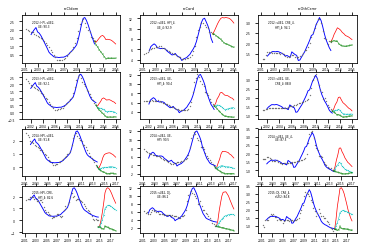

In [69]:
plt.rcParams.update({'font.size': 3})

ver = 0     ## 0, 1, 2 only
plst = [6,7,8]  ## indices for rcCIdom, rcCard, rcOthCsmr in curlst
ylst = [2012,2013,2014,2015]
zlst = ['r3','r3','r3']

styp = suff

for i in np.arange(4):

  if i == 0:
    fdf = f12r3
    pdf = pz[pz['yr']==2012]
  elif i == 1:
    fdf = f13r3
    pdf = pz[pz['yr']==2013]
  elif i == 2:
    fdf = f14r3
    pdf = pz[pz['yr']==2014]
  elif i == 3:
    fdf = f15r3
    pdf = pz[pz['yr']==2015]

  yr = ylst[i]
  xa = list(fdf.index)
  xaz = [x for x in xa if x <= pd.to_datetime(str(ylst[i]-1)+'-09-30')]

  for j in np.arange(3):
    plt.subplot(4, 3, i*3+j+1)
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc1'].values[0],\
                 xy=(0.1, 0.84), xycoords='axes fraction', fontsize=2.7) # var listing annotation
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc2'].values[0],\
                 xy=(0.17, 0.75), xycoords='axes fraction', fontsize=2.7) # var listing annotation

    if i == 0:
      plt.title(curlst[plst[j]])

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+"_allyr_" + str(qtyp) + "q_4v_problem3a_"+styp+"_"+str(ver)+'.png', dpi=400, bbox_inches='tight')
plt.show()

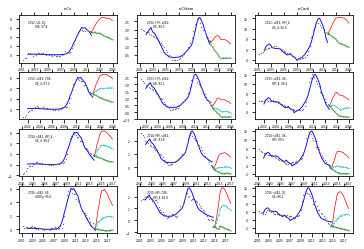

In [70]:
# alt hist, fitted
plt.rcParams.update({'font.size': 3})

ver = 0     ## 0, 1, 2 only
plst = [1,6,7]  ## indices for rcCx, rcCIdom, rcCard in curlst
ylst = [2012,2013,2014,2015]
zlst = ['r3','r3','r3']

styp = suff

for i in np.arange(4):

  if i == 0:
    fdf = f12r3
    pdf = pz[pz['yr']==2012]
  elif i == 1:
    fdf = f13r3
    pdf = pz[pz['yr']==2013]
  elif i == 2:
    fdf = f14r3
    pdf = pz[pz['yr']==2014]
  elif i == 3:
    fdf = f15r3
    pdf = pz[pz['yr']==2015]

  yr = ylst[i]
  xa = list(fdf.index)
  xaz = [x for x in xa if x <= pd.to_datetime(str(ylst[i]-1)+'-09-30')]

  for j in np.arange(3):
    plt.subplot(4, 3, i*3+j+1)
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc1'].values[0],\
                 xy=(0.1, 0.84), xycoords='axes fraction', fontsize=2.7) # var listing annotation
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc2'].values[0],\
                 xy=(0.17, 0.75), xycoords='axes fraction', fontsize=2.7) # var listing annotation
    
    if i == 0:
      plt.title(curlst[plst[j]])

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+"_allyr_" + str(qtyp) + "q_4v_problem3b_"+styp+"_"+str(ver)+'.png', dpi=400, bbox_inches='tight')
plt.show()

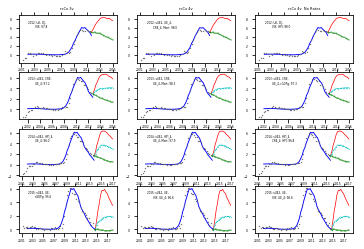

In [71]:
plt.rcParams.update({'font.size': 3})

ver = 0     ## 0, 1, 2 only
plst = [1,1,1]  ## index for rcCx
ylst = [2012,2013,2014,2015]
zlst = ['r3','r4','n4']
z1lst = [' 3v ',' 4v ',' 4v ']
nrlst = ['','',' No Rates']

styp = suff

for i in np.arange(4):

  if i == 0:
    fdfa = f12r3
    fdfb = f12r
    fdfc = f12n
    pdf = pz[pz['yr']==2012]
  elif i == 1:
    fdfa = f13r3
    fdfb = f13r
    fdfc = f13n
    pdf = pz[pz['yr']==2013]
  elif i == 2:
    fdfa = f14r3
    fdfb = f14r
    fdfc = f14n
    pdf = pz[pz['yr']==2014]
  elif i == 3:
    fdfa = f15r3
    fdfb = f15r
    fdfc = f15n
    pdf = pz[pz['yr']==2015]

  yr = ylst[i]
  xa = list(fdfa.index)
  xaz = [x for x in xa if x <= pd.to_datetime(str(ylst[i]-1)+'-09-30')]

  for j in np.arange(3):
    if j==0: 
      fdf = fdfa
    elif j == 1:
      fdf = fdfb
    elif j == 2:
      fdf = fdfc
    plt.subplot(4, 3, i*3+j+1)
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    #r2 = curlst[plst[j]]+str(j)
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc1'].values[0],\
                 xy=(0.1, 0.84), xycoords='axes fraction', fontsize=2.7) # var listing annotation
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc2'].values[0],\
                 xy=(0.17, 0.75), xycoords='axes fraction', fontsize=2.7) # var listing annotation

    if i == 0:
      plt.title(curlst[plst[j]]+z1lst[j]+nrlst[j])

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+"_allyr_" + str(qtyp) + "q_"+curlst[plst[0]]+"_"+styp+"_"+str(ver)+'.png', dpi=400, bbox_inches='tight')
plt.show()

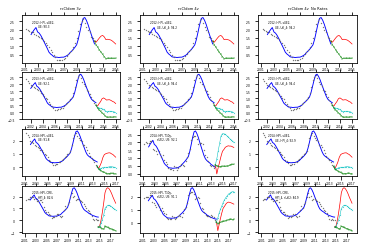

In [72]:
plt.rcParams.update({'font.size': 3})

ver = 0     ## 0, 1, 2 only
plst = [6,6,6]  ## index for rcCIdom
ylst = [2012,2013,2014,2015]
zlst = ['r3','r4','n4']
z1lst = [' 3v ',' 4v ',' 4v ']
nrlst = ['','',' No Rates']

styp = suff

for i in np.arange(4):

  if i == 0:
    fdfa = f12r3
    fdfb = f12r
    fdfc = f12n
    pdf = pz[pz['yr']==2012]
  elif i == 1:
    fdfa = f13r3
    fdfb = f13r
    fdfc = f13n
    pdf = pz[pz['yr']==2013]
  elif i == 2:
    fdfa = f14r3
    fdfb = f14r
    fdfc = f14n
    pdf = pz[pz['yr']==2014]
  elif i == 3:
    fdfa = f15r3
    fdfb = f15r
    fdfc = f15n
    pdf = pz[pz['yr']==2015]

  yr = ylst[i]
  xa = list(fdfa.index)
  xaz = [x for x in xa if x <= pd.to_datetime(str(ylst[i]-1)+'-09-30')]

  for j in np.arange(3):
    if j==0: 
      fdf = fdfa
    elif j == 1:
      fdf = fdfb
    elif j == 2:
      fdf = fdfc
    plt.subplot(4, 3, i*3+j+1)
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    #r2 = curlst[plst[j]]+str(j)
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc1'].values[0],\
                 xy=(0.1, 0.84), xycoords='axes fraction', fontsize=2.7) # var listing annotation
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc2'].values[0],\
                 xy=(0.17, 0.75), xycoords='axes fraction', fontsize=2.7) # var listing annotation

    if i == 0:
      plt.title(curlst[plst[j]]+z1lst[j]+nrlst[j])

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+"_allyr_" + str(qtyp) + "q_"+curlst[plst[0]]+"_"+styp+"_"+str(ver)+'.png', dpi=400, bbox_inches='tight')
plt.show()

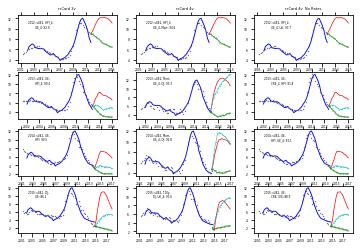

In [73]:
plt.rcParams.update({'font.size': 3})

ver = 0     ## 0, 1, 2 only
plst = [7,7,7]  ## index for rcCard
ylst = [2012,2013,2014,2015]
zlst = ['r3','r4','n4']
z1lst = [' 3v ',' 4v ',' 4v ']
nrlst = ['','',' No Rates']

styp = suff

for i in np.arange(4):

  if i == 0:
    fdfa = f12r3
    fdfb = f12r
    fdfc = f12n
    pdf = pz[pz['yr']==2012]
  elif i == 1:
    fdfa = f13r3
    fdfb = f13r
    fdfc = f13n
    pdf = pz[pz['yr']==2013]
  elif i == 2:
    fdfa = f14r3
    fdfb = f14r
    fdfc = f14n
    pdf = pz[pz['yr']==2014]
  elif i == 3:
    fdfa = f15r3
    fdfb = f15r
    fdfc = f15n
    pdf = pz[pz['yr']==2015]

  yr = ylst[i]
  xa = list(fdfa.index)
  xaz = [x for x in xa if x <= pd.to_datetime(str(ylst[i]-1)+'-09-30')]

  for j in np.arange(3):
    if j==0: 
      fdf = fdfa
    elif j == 1:
      fdf = fdfb
    elif j == 2:
      fdf = fdfc
    plt.subplot(4, 3, i*3+j+1)
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,fdf.ix[:str(ylst[i]-1)+'-09-30'][curlst[plst[j]]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xa,fdf[curlst[plst[j]]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    #r2 = curlst[plst[j]]+str(j)
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc1'].values[0],\
                 xy=(0.1, 0.84), xycoords='axes fraction', fontsize=2.7) # var listing annotation
    plt.annotate(pdf[(pdf['rc']==curlst[plst[j]]+str(ver))&(pdf['rn']==zlst[j])]['Desc2'].values[0],\
                 xy=(0.17, 0.75), xycoords='axes fraction', fontsize=2.7) # var listing annotation

    if i == 0:
      plt.title(curlst[plst[j]]+z1lst[j]+nrlst[j])

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+"_allyr_" + str(qtyp) + "q_"+curlst[plst[0]]+"_"+styp+"_"+str(ver)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [74]:
## section for misc. NCO charts

In [75]:
df = pd.read_csv("FailRates_all2.csv") 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',drop=True,inplace=True)
df.head(2)

CBfail  CBnbr    FailRt  FailRt4q
Date                                         
1976-03-31       5  14410  0.138793  0.104235
1976-06-30       6  14410  0.166551  0.125026

In [76]:
vo.head(2)  ## Call Data w/calculated cols:

Grp  IDRSSD   nbr         Cert       eTotAst  \
Date                                                               
2001-03-31  grpTotUSx00       0  8857  157908377.0  6.619299e+09   
2001-06-30  grpTotUSx00       0  8790  157950414.0  6.670875e+09   

                  eTotLn       eALLL      eOREO         eGW  OthIntang  \
Date                                                                     
2001-03-31  4.019129e+09  66654030.0  3654979.0  62574356.0        0.0   
2001-06-30  4.052104e+09  67717331.0  3794355.0  65356631.0        0.0   

              ...         eTotrb  eALLL_Ln      mxCx    mxSfFst      mxCRE  \
Date          ...                                                            
2001-03-31    ...      12.424229  1.658420  4.526967  19.886307  12.274656   
2001-06-30    ...      12.556711  1.671165  4.757107  19.959003  12.389330   

                 mxCI    mxCard      mxDDA    eRWA_TA   lnTotAst  
Date                                                              
2001-03-31  24.493310  5.417228  19.002339  77.388279  22.613255  
2001-06-30  23.792958  5.606277  19.502725  77.331733  22.621017  

[2 rows x 321 columns]

In [77]:
frrc = df.ix['2001':][['FailRt','FailRt4q']]
vorc = vo[['rcTotLn','eTotLn']]

In [78]:
frrc.tail(2)

FailRt  FailRt4q
Date                        
2018-03-31     0.0  0.101122
2018-06-30     0.0  0.040816

In [79]:
vorc.tail(2)

rcTotLn        eTotLn
Date                              
2018-03-31  0.492093  9.752384e+09
2018-06-30  0.491822  9.856591e+09

In [80]:
len(frrc),len(vorc) # 68, 68

(70, 70)

In [81]:
frrc2 = frrc.merge(vorc,how='left',left_index=True,right_index=True)
frrc2.tail()

FailRt  FailRt4q   rcTotLn        eTotLn
Date                                                  
2017-06-30  0.239473  0.157217  0.481595  9.458208e+09
2017-09-30  0.000000  0.119089  0.486417  9.556943e+09
2017-12-31  0.162668  0.160337  0.492281  9.721063e+09
2018-03-31  0.000000  0.101122  0.492093  9.752384e+09
2018-06-30  0.000000  0.040816  0.491822  9.856591e+09

In [82]:
if 'eTotLn' in list(frrc2.columns): frrc2.drop('eTotLn',axis=1,inplace=True)
frrc2 = frrc2.ix['2001-12-31':]
frrc2.head()

FailRt  FailRt4q   rcTotLn
Date                                    
2001-12-31  0.000000  0.037030  0.906950
2002-03-31  0.301925  0.099447  1.003935
2002-06-30  0.050563  0.100084  1.068781
2002-09-30  0.050787  0.100759  1.114087
2002-12-31  0.102132  0.126707  1.063023

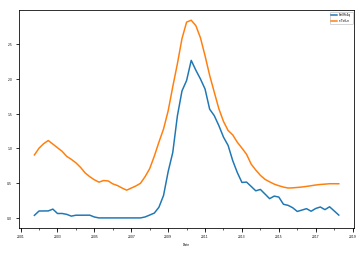

In [83]:
frrc2[['FailRt4q','rcTotLn']].plot()

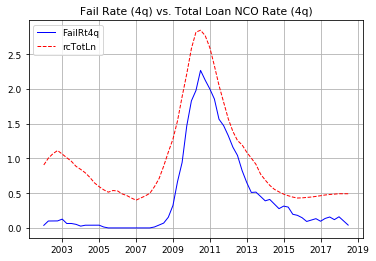

In [84]:
plt.rcParams.update({'font.size': 9})
xax = list(frrc2.index)
    
for i in [0]:
  plt.plot(xax,frrc2['FailRt4q'],ls='-',c='b',lw=1,label='FailRt4q')
#  plt.plot(xax,frrc2[curlst[i],'Fit'],ls='None', marker='o',c='w',ms=3,label='Fitted')
  plt.plot(xax,frrc2['rcTotLn'],ls='--',c='r',lw=1,label='rcTotLn')
#  plt.plot(xax,frrc2[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=3,c='c',label='Adverse')
#  plt.plot(xax,frrc2[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=3,label='Base')
#  plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
  plt.legend(loc=2)
  plt.grid(True)
  plt.title('Fail Rate (4q) vs. Total Loan NCO Rate (4q)')
plt.savefig(grp+'_'+'FailRt4q_rcTotLn'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [85]:
curlst3 = ['rcSfRev','rcSfTD','rcCIdom','rcCIfor','rcCard','rcCx','rcOthCsmr','rcCRE','rcMult','rcTotLn','rcCREtot']
curlst3

['rcSfRev',
 'rcSfTD',
 'rcCIdom',
 'rcCIfor',
 'rcCard',
 'rcCx',
 'rcOthCsmr',
 'rcCRE',
 'rcMult',
 'rcTotLn',
 'rcCREtot']

In [86]:
vor = vo.ix['2001-12-31':][curlst3]
vor.head(2)

rcSfRev    rcSfTD   rcCIdom   rcCIfor    rcCard      rcCx  \
Date                                                                     
2001-12-31  0.254723  0.198517  1.712288  0.619878  5.685286  0.128401   
2002-03-31  0.238045  0.206689  1.870484  0.801101  6.531011  0.140850   

            rcOthCsmr     rcCRE    rcMult   rcTotLn  rcCREtot  
Date                                                           
2001-12-31   1.381422  0.123373  0.028189  0.906950  0.115373  
2002-03-31   1.473849  0.139262  0.029043  1.003935  0.129027

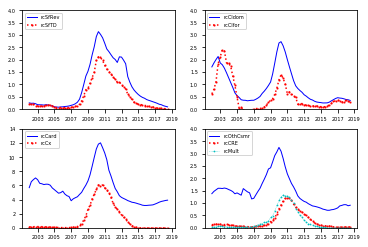

In [87]:
# 4 panel NCO rate charts:
xax = list(vor.index)
plt.rcParams.update({'font.size': 5})

for i in np.arange(4):
  plt.subplot(2, 2, i+1)
  plt.plot(xax,vor[curlst3[i*2]],ls='-',c='b',lw=1, label=curlst3[i*2])
  plt.plot(xax,vor[curlst3[i*2+1]],ls=':', marker='x',c='r',ms=1.5, label=curlst3[i*2+1])
  if i==3: plt.plot(xax,vor[curlst3[i*2+2]],ls=':',lw=.5,marker='.',c='c',ms=1.5, label=curlst3[i*2+2])

  yx = 4
  if i==2: yx = 14

  plt.legend(loc=2)
#  plt.ylim(0,yx)  ## doesn't work!!
  # alternative ylim:
  axes = plt.gca()
  #axes.set_xlim([xmin,xmax])
  axes.set_ylim([0,yx])

plt.savefig(grp+'_'+'all9nco'+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [88]:
## prep annual tables for bals, NCO rates, NCO vols

In [89]:
curlst2 = curlst + ['rcCIfor']
curlst2

['rcTotLn',
 'rcCx',
 'rcSfRev',
 'rcSfTD',
 'rcMult',
 'rcCRE',
 'rcCIdom',
 'rcCard',
 'rcOthCsmr',
 'rcCREtot',
 'rcCIfor']

In [90]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(curlst, nmlst))
dmz = dict(zip(curlst, dmlst))

nmlst2 = nmlst + ['qncCIfor']
dmlst2 = dmlst + ['eCIfor']

nmz2 = dict(zip(curlst2, nmlst2))
dmz2 = dict(zip(curlst2, dmlst2))

dmlst2, nmlst2

(['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr',
  'eCREtot',
  'eCIfor'],
 ['qncTotLn',
  'qncCx',
  'qncSfRev',
  'qncSfTD',
  'qncMult',
  'qncCRE',
  'qncCIdom',
  'qncCard',
  'qncOthCsmr',
  'qncCREtot',
  'qncCIfor'])

In [91]:
nmz2

{'rcCIdom': 'qncCIdom',
 'rcCIfor': 'qncCIfor',
 'rcCRE': 'qncCRE',
 'rcCREtot': 'qncCREtot',
 'rcCard': 'qncCard',
 'rcCx': 'qncCx',
 'rcMult': 'qncMult',
 'rcOthCsmr': 'qncOthCsmr',
 'rcSfRev': 'qncSfRev',
 'rcSfTD': 'qncSfTD',
 'rcTotLn': 'qncTotLn'}

In [92]:
bal = vo[dmlst2]
qr = vo[curlst2]
co = vo[nmlst2]

In [93]:
bal.head(2)

eTotLn          eCx       eSfRev        eSfTD       eMult  \
Date                                                                          
2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0  74421523.0   
2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0  74003767.0   

                   eCRE       eCIdom        aCard     aOthCsmr      eCREtot  \
Date                                                                          
2001-03-31  493334312.0  832079914.0  205311052.0  359867608.0  749700492.0   
2001-06-30  502028474.0  812822577.0  205481263.0  366821155.0  768795133.0   

                 eCIfor  
Date                     
2001-03-31  152337927.0  
2001-06-30  151292723.0

In [94]:
qr.tail(2)

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult     rcCRE  \
Date                                                                     
2018-03-31  0.492093 -0.015738  0.116681  0.020003 -0.005648  0.032398   
2018-06-30  0.491822 -0.015656  0.094093  0.014366 -0.006158  0.032933   

             rcCIdom    rcCard  rcOthCsmr  rcCREtot   rcCIfor  
Date                                                           
2018-03-31  0.381997  3.871573   0.893449  0.017580  0.332823  
2018-06-30  0.354432  3.914776   0.913291  0.017798  0.272095

In [95]:
co.tail(2)

qncTotLn    qncCx  qncSfRev   qncSfTD  qncMult    qncCRE  \
Date                                                                     
2018-03-31  12061948.0 -30231.0  107566.0  105910.0  -3689.0   48502.0   
2018-06-30  11676437.0 -39167.0   30528.0  -21830.0  -4152.0  100664.0   

             qncCIdom    qncCard  qncOthCsmr  qncCREtot  qncCIfor  
Date                                                               
2018-03-31  1304699.0  8205707.0   1835687.0    14582.0  116371.0  
2018-06-30  1332230.0  8091512.0   1654353.0    57345.0   59007.0

In [96]:
balyr = bal.resample('A').mean()
balyr.tail()

eTotLn           eCx        eSfRev         eSfTD  \
Date                                                                 
2014-12-31  8.127401e+09  2.266471e+08  4.974579e+08  1.836763e+09   
2015-12-31  8.597682e+09  2.606967e+08  4.746626e+08  1.881654e+09   
2016-12-31  9.149398e+09  2.988380e+08  4.470579e+08  1.965758e+09   
2017-12-31  9.508335e+09  3.281226e+08  4.206203e+08  2.027651e+09   
2018-12-31  9.804487e+09  3.455538e+08  3.937418e+08  2.081546e+09   

                   eMult          eCRE        eCIdom         aCard  \
Date                                                                 
2014-12-31  2.849389e+08  1.131928e+09  1.375140e+09  6.304421e+08   
2015-12-31  3.233893e+08  1.192569e+09  1.506914e+09  6.586402e+08   
2016-12-31  3.686119e+08  1.288721e+09  1.627482e+09  7.092285e+08   
2017-12-31  3.982192e+08  1.370267e+09  1.646056e+09  7.567341e+08   
2018-12-31  4.149916e+08  1.412111e+09  1.702594e+09  7.991736e+08   

                aOthCsmr       eCREtot        eCIfor  
Date                                                  
2014-12-31  6.625821e+08  1.643514e+09  2.476222e+08  
2015-12-31  7.010637e+08  1.776655e+09  2.507127e+08  
2016-12-31  7.466419e+08  1.956171e+09  2.631637e+08  
2017-12-31  7.738291e+08  2.096609e+09  2.646241e+08  
2018-12-31  7.907918e+08  2.172656e+09  2.826623e+08

In [97]:
coyr = co.resample('A').sum()
coyr.tail()

qncTotLn     qncCx   qncSfRev    qncSfTD  qncMult     qncCRE  \
Date                                                                         
2014-12-31  39549045.0   66196.0  2962080.0  3687271.0  66611.0  1131763.0   
2015-12-31  37217391.0 -120878.0  1851291.0  2750554.0   3656.0   853938.0   
2016-12-31  42417495.0  -87524.0  1213388.0  1180631.0   6655.0   204565.0   
2017-12-31  46807685.0  -59358.0   596153.0   513698.0 -25788.0   484902.0   
2018-12-31  23738385.0  -69398.0   138094.0    84080.0  -7841.0   149166.0   

             qncCIdom     qncCard  qncOthCsmr  qncCREtot  qncCIfor  
Date                                                                
2014-12-31  3660020.0  21409814.0   5252119.0  1264570.0  259868.0  
2015-12-31  4288010.0  20850829.0   4968171.0   736716.0  397447.0  
2016-12-31  7574298.0  23860276.0   6014257.0   123696.0  950862.0  
2017-12-31  6453880.0  28764997.0   7234091.0   399756.0  946312.0  
2018-12-31  2636929.0  16297219.0   3490040.0    71927.0  175378.0

In [98]:
qr1 = qr.reset_index(drop=False)
qr1.tail(2)

Date   rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult     rcCRE  \
68 2018-03-31  0.492093 -0.015738  0.116681  0.020003 -0.005648  0.032398   
69 2018-06-30  0.491822 -0.015656  0.094093  0.014366 -0.006158  0.032933   

     rcCIdom    rcCard  rcOthCsmr  rcCREtot   rcCIfor  
68  0.381997  3.871573   0.893449  0.017580  0.332823  
69  0.354432  3.914776   0.913291  0.017798  0.272095

In [99]:
dec_mask = qr1['Date'].map(lambda x: x.month) == 12
qryr = qr1[dec_mask]
qryr.tail(8)

Date   rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult     rcCRE  \
39 2010-12-31  2.594293  5.668405  2.670633  1.773350  1.301994  1.220345   
43 2011-12-31  1.570727  3.469998  2.082288  1.295532  0.777853  0.835870   
47 2012-12-31  1.089064  1.809530  2.108715  0.999322  0.312235  0.545349   
51 2013-12-31  0.689300  0.513138  1.088851  0.498517  0.102301  0.262749   
55 2014-12-31  0.486614  0.029207  0.595443  0.200748  0.023377  0.099985   
59 2015-12-31  0.432877 -0.046367  0.390023  0.146177  0.001131  0.071605   
63 2016-12-31  0.463610 -0.029288  0.271416  0.060060  0.001805  0.015873   
67 2017-12-31  0.492281 -0.018090  0.141732  0.025335 -0.006476  0.035387   

     rcCIdom     rcCard  rcOthCsmr  rcCREtot   rcCIfor  
39  2.007685  10.601404   2.184110  2.238946  0.631461  
43  0.945453   6.409972   1.485802  1.294214  0.475536  
47  0.585041   4.303986   1.068634  0.690695  0.173812  
51  0.370908   3.742273   0.885846  0.270177  0.126893  
55  0.266156   3.396000   0.792674  0.076943  0.104945  
59  0.284556   3.165739   0.708662  0.041466  0.158527  
63  0.465400   3.364258   0.805508  0.006323  0.361320  
67  0.392081   3.801202   0.934844  0.019067  0.357606

In [100]:
qryr.to_csv(grp+'_annNCOrts.csv')  ## annual NCO rates
coyr.to_csv(grp+'_annNCOvol.csv')  ## annual NCO volumes
balyr.to_csv(grp+'_annavglnbal.csv')  ## annual avg loan balances